<a href="https://colab.research.google.com/github/FajarKKP/ML-DL_related_project/blob/main/SIBI_ImageDataGenerator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import sklearn
import numpy as np

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [21]:
# Initialize batch size and image size
batch_size = 32
image_size = (224,224)


In [22]:
#For Augmentation
train_datagen = ImageDataGenerator(
                    horizontal_flip=True)
 
test_datagen = ImageDataGenerator()

In [23]:

train_generator = train_datagen.flow_from_directory(
        '/content/drive/MyDrive/testing_folder/train', 
        target_size=image_size, 
        batch_size=batch_size,
        shuffle = True,
        class_mode='sparse')
 
val_generator = test_datagen.flow_from_directory(
        '/content/drive/MyDrive/testing_folder/val', 
        target_size=image_size, 
        batch_size=batch_size,
        # shuffle = True,
        class_mode='sparse')

test_generator = test_datagen.flow_from_directory(
        '/content/drive/MyDrive/testing_folder/test', 
        target_size=image_size, 
        batch_size=batch_size,
        class_mode='sparse')

Found 9600 images belonging to 24 classes.
Found 1200 images belonging to 24 classes.
Found 1200 images belonging to 24 classes.


In [24]:
# Import the EfficientNet model
eff_model1 = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False, input_shape=(224,224,3))
print(type(eff_model1))
eff_model1.summary()

16719872/16705208 [==============================] - 0s 0us/step
<class 'keras.engine.functional.Functional'>
Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                          

In [25]:
# Set false to trainable, then set the dropout rate we will use for our model
eff_model1.trainable = False
dropout_rate = 0.1 #@param {type:"slider", min:0, max:1, step:0.1}

In [26]:
# Create a new model, combining the EfficientNet and new output layer with 24 output class

model = models.Sequential()
model.add(eff_model1)
model.add(layers.GlobalMaxPooling2D(name="gap"))
# model.add(layers.Flatten(name="flatten"))
if dropout_rate > 0:
    model.add(layers.Dropout(dropout_rate, name="dropout_out"))

model.add(layers.Dense(24, activation="softmax", name="fc_out"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 gap (GlobalMaxPooling2D)    (None, 1280)              0         
                                                                 
 dropout_out (Dropout)       (None, 1280)              0         
                                                                 
 fc_out (Dense)              (None, 24)                30744     
                                                                 
Total params: 4,080,315
Trainable params: 30,744
Non-trainable params: 4,049,571
_________________________________________________________________


In [27]:
# Train model
epochs = 50
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epochs, logs={}):
    if(logs.get('accuracy')>0.98):
      print("\n Good enough, its above 98%")
      self.model.stop_training=True
callbacks = myCallback()

save_callback = keras.callbacks.ModelCheckpoint(
    '/content/drive/MyDrive/Hasil_model_EfficientNet/callback_checkpoint',
    monitor = 'accuracy',
    save_best_only=True
)
# early_stopping = keras.callbacks.EarlyStopping(
#     monitor="accuracy",
#     patience=5,
  
# )
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy", 
    metrics=['accuracy'],
)
final_model = model.fit(train_generator, epochs=epochs, callbacks=[callbacks, save_callback], validation_data=val_generator)

Epoch 1/50
300/300 [==============================] - 3000s 10s/step - loss: 1.9887 - accuracy: 0.5715 - val_loss: 0.6344 - val_accuracy: 0.8125
Epoch 2/50
300/300 [==============================] - 698s 2s/step - loss: 0.5241 - accuracy: 0.8482 - val_loss: 0.2104 - val_accuracy: 0.9333
Epoch 3/50
300/300 [==============================] - 713s 2s/step - loss: 0.2993 - accuracy: 0.9021 - val_loss: 0.1851 - val_accuracy: 0.9433
Epoch 4/50
300/300 [==============================] - 718s 2s/step - loss: 0.2501 - accuracy: 0.9223 - val_loss: 0.0729 - val_accuracy: 0.9792
Epoch 5/50
300/300 [==============================] - 714s 2s/step - loss: 0.1826 - accuracy: 0.9427 - val_loss: 0.0556 - val_accuracy: 0.9842
Epoch 6/50
300/300 [==============================] - 719s 2s/step - loss: 0.1452 - accuracy: 0.9535 - val_loss: 0.0679 - val_accuracy: 0.9792
Epoch 7/50
300/300 [==============================] - 720s 2s/step - loss: 0.1235 - accuracy: 0.9583 - val_loss: 0.0692 - val_accuracy: 0.97

In [28]:
model.save('/content/drive/MyDrive/Hasil_model_EfficientNet/final_model_generator_fix.h5')

In [29]:
# final_model = keras.models.load_model("/content/drive/MyDrive/Hasil_model_EfficientNet/final_model_generator_tanpa_rotate.h5")

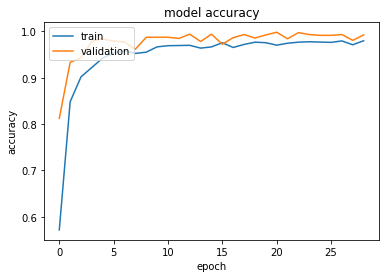

In [30]:
def plot_hist(final_model):
    plt.plot(final_model.history["accuracy"])
    plt.plot(final_model.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(final_model)

In [32]:
final_model.evaluate(test_generator)

AttributeError: ignored